<a href="https://colab.research.google.com/github/ywang1110/Modeling_Triboelectric_Performance/blob/main/Humidity___PP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from sklearn.feature_selection import f_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare dataset

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('drive/My Drive/0 Sarah PP/0 Data/Humidity/Sarah_PP.xlsx')
df.head()

,Unnamed: 0,Label,ChargeDensity(µC/m2) j,Thickness(um),solidity,diameter(um),Interface(mm),Tem,Humidity (%),Force (N)
0,0,S-1,13.233000,524.766667,0.088333,6.184,1.123,25.133333,47.633333,36.133333
1,1,S-11,19.201667,360.533333,0.127333,3.296,0.765,24.766667,50.033333,36.433333
2,2,S-13,10.868000,537.533333,0.087667,6.238,1.429,25.733333,45.600000,36.766667
3,3,S-14,19.316333,404.166667,0.118667,3.580,0.752,24.600000,49.466667,35.800000
4,4,S-15,26.553667,316.933333,0.148667,2.554,0.857,25.600000,45.033333,36.100000


In [4]:
df.shape

(17, 10)

## Unit conversion

In [5]:
data = pd.DataFrame()
data['ChargeDensity(C/m2)']=df['ChargeDensity(µC/m2) j']*pow(10,-6)
data['thickness(m)']=df['Thickness(um)']*pow(10,-6)
data['solidity'] = df['solidity']
data['diameter(m)'] = df['diameter(um)']*pow(10,-6)
data['Interface(m)']=df['Interface(mm)']*pow(10, -3)
data[['Tem (°C)', 'Humidity (%)', 'Force (N)']]=df[['Tem', 'Humidity (%)', 'Force (N)']]

data.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Humidity (%),Force (N)
0,0.000013,0.000525,0.088333,0.000006,0.001123,25.133333,47.633333,36.133333
1,0.000019,0.000361,0.127333,0.000003,0.000765,24.766667,50.033333,36.433333
2,0.000011,0.000538,0.087667,0.000006,0.001429,25.733333,45.600000,36.766667
3,0.000019,0.000404,0.118667,0.000004,0.000752,24.600000,49.466667,35.800000
4,0.000027,0.000317,0.148667,0.000003,0.000857,25.600000,45.033333,36.100000


In [6]:
data.shape

(17, 8)

# Train test split

In [7]:
random_state=15

kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
train_indexs = []
test_indexs = []
for train_index, test_index in kf.split(data):
    train_indexs.append(train_index)
    test_indexs.append(test_index)
index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
index

,train_index,test_index
0,"[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]","[2, 3, 4, 16]"
1,"[0, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16]","[1, 9, 10, 11]"
2,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16]","[6, 13, 14]"
3,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16]","[0, 7, 15]"
4,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 16]","[5, 8, 12]"


In [8]:
n_fold=2

In [9]:
train_index = index.iloc[n_fold,0]
test_index = index.iloc[n_fold,1]
train, test = data.iloc[train_index], data.iloc[test_index]
train.shape

(14, 8)

In [10]:
train.shape

(14, 8)

In [11]:
test.shape

(3, 8)

In [12]:
"""
train.to_csv('train.csv')
test.to_csv('test.csv')
"""


"\ntrain.to_csv('train.csv')\ntest.to_csv('test.csv')\n"

In [13]:
"""
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
"""

"\ntrain = pd.read_csv('train.csv')\ntest=pd.read_csv('test.csv')\n"

In [14]:
train.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Humidity (%),Force (N)
0,0.000013,0.000525,0.088333,0.000006,0.001123,25.133333,47.633333,36.133333
1,0.000019,0.000361,0.127333,0.000003,0.000765,24.766667,50.033333,36.433333
2,0.000011,0.000538,0.087667,0.000006,0.001429,25.733333,45.600000,36.766667
3,0.000019,0.000404,0.118667,0.000004,0.000752,24.600000,49.466667,35.800000
4,0.000027,0.000317,0.148667,0.000003,0.000857,25.600000,45.033333,36.100000


In [15]:
# Train the model
x=train['thickness(m)'].to_numpy()
y=train['solidity'].to_numpy()
z=train['diameter(m)'].to_numpy()
u=train['Interface(m)'].to_numpy()
h=train['Humidity (%)'].to_numpy()
j=train['ChargeDensity(C/m2)'].to_numpy()
def func(X,a, w, c, m, n, p):
  x,y,z,u,h = X
  return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

# lm
popt_lm,pcov = curve_fit(func,(x,y,z,u,h),j, method='lm', maxfev = 50000)
y_model_lm = func((x,y,z,u, h),popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5]) 
MSE_lm = mean_squared_error(j, y_model_lm)
MAE_lm = mean_absolute_error(j, y_model_lm)
lm_result="lm Method | MSE = {:.2E}| MAE = {:.2E}| a = {:.2E}, w = {:.2E}, c = {:.2E},m = {:.2E}, n = {:.2E}, p = {:.2E}".format(MSE_lm,MAE_lm,popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5])
lm_result  

'lm Method | MSE = 1.05E-12| MAE = 8.26E-07| a = -1.79E-02, w = -1.21E-06, c = 2.00E+00,m = 1.00E+00, n = 1.00E+00, p = 1.00E+00'

In [16]:
# initial guesses for a,b,c,m,n,p:
p0 = 1E-6 , 0 ,1. , 1. , 1., 1.

In [17]:
  # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=50000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=50000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  print(trf_result)
  print(dog_result)

trf Method is the best method
trf Method | MSE = 1.67E-12| MAE = 1.12E-06| a = 8.309408307161337e-06, w = 7.688946289697118e-08, c = 1.0758662652890962,m = 0.9958186268716754, n = 1.134083082339703, p = 1.118072471232824
dog Method | MSE = 1.31E-11| MAE = 3.27E-06| a = 1.2991944980965748e-05, w = 1.649999806367021e-07, c = 1.7522583051677183,m = 1.0002198454704512, n = 1.0003479637949864, p = 1.0001216962282173


In [18]:
  # Validate (when trf is best)

  data_val = pd.concat([train, test])
  data_val.head()
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Humidity (%)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()

  


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  data_val['ratio(%)'] = (data_val['Predicted(C/m2)'] -data_val['ChargeDensity(C/m2)'])/data_val['ChargeDensity(C/m2)']*100
  data_val['ChargeDensity(uC/m2)'] = data_val['ChargeDensity(C/m2)']*pow(10,6)
  data_val['Predicted(uC/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)*pow(10,6)
  data_val['ratio_2(%)'] = (data_val['Predicted(uC/m2)']-data_val['ChargeDensity(uC/m2)'])/data_val['ChargeDensity(uC/m2)']*100
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])
  
  print('MAPE= {:.2f}'.format(mape))
  print('Train_MAPE = {:.2f}'.format(mape_train))
  print('test_MAPE = {:.2f}'.format(mape_test))

MAPE= 8.68
Train_MAPE = 8.05
test_MAPE = 11.59


In [19]:
data_val

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%)
0,0.000013,0.000525,0.088333,0.000006,0.001123,25.133333,47.633333,36.133333,0.000012,-11.719225,13.233000,11.682195,-11.719225
1,0.000019,0.000361,0.127333,0.000003,0.000765,24.766667,50.033333,36.433333,0.000019,1.068539,19.201667,19.406844,1.068539
2,0.000011,0.000538,0.087667,0.000006,0.001429,25.733333,45.600000,36.766667,0.000012,7.916343,10.868000,11.728348,7.916343
3,0.000019,0.000404,0.118667,0.000004,0.000752,24.600000,49.466667,35.800000,0.000018,-5.142341,19.316333,18.323022,-5.142341
4,0.000027,0.000317,0.148667,0.000003,0.000857,25.600000,45.033333,36.100000,0.000026,-2.073906,26.553667,26.002969,-2.073906
5,0.000015,0.000438,0.098333,0.000004,0.000886,26.166667,40.066667,35.866667,0.000017,14.048699,15.099333,17.220593,14.048699
7,0.000007,0.000664,0.070000,0.000010,0.001815,25.466667,48.566667,37.100000,0.000008,10.681389,6.776333,7.500140,10.681389
8,0.000012,0.000497,0.088667,0.000005,0.001180,24.633333,49.133333,36.433333,0.000012,-2.000934,12.183667,11.939879,-2.000934
9,0.000019,0.000414,0.109333,0.000004,0.000760,25.100000,47.566667,36.433333,0.000017,-9.006705,18.707000,17.022116,-9.006705
10,0.000009,0.000743,0.059667,0.000009,0.002673,26.000000,44.766667,38.100000,0.000007,-20.729207,8.550333,6.777917,-20.729207


In [35]:
data_val.describe()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%)
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.000016,0.000491,0.105294,0.000004,0.001238,25.337255,47.323529,36.482353,0.000016,0.383330,16.269294,16.304748,0.383330
std,0.000005,0.000101,0.021843,0.000002,0.000468,0.521600,2.526684,0.564840,0.000005,10.565213,4.812006,4.881916,10.565213
min,0.000007,0.000317,0.059667,0.000002,0.000752,24.600000,40.066667,35.800000,0.000007,-20.729207,6.776333,6.777917,-20.729207
25%,0.000013,0.000438,0.088667,0.000003,0.000886,25.000000,46.133333,36.100000,0.000012,-6.782257,13.233000,11.939879,-6.782257
50%,0.000017,0.000493,0.109333,0.000004,0.001180,25.400000,47.633333,36.433333,0.000017,0.908338,17.164667,17.355769,0.908338
75%,0.000019,0.000525,0.120333,0.000005,0.001369,25.733333,48.933333,36.766667,0.000019,8.688668,19.316333,18.865158,8.688668
max,0.000027,0.000743,0.148667,0.000010,0.002673,26.166667,50.766667,38.100000,0.000026,16.288598,26.553667,26.002969,16.288598


# Simulation

In [39]:
label = 1
set_thickness = data.loc[label]['thickness(m)']
set_solidity = data.loc[label]['solidity']
set_diameter = data.loc[label]['diameter(m)']
set_u = data.loc[label]['Interface(m)']
set_h = data.loc[label]['Humidity (%)']
print('set_thickness = {:.3E}\nset_solidity = {:.3f}\nset_diameter = {:.2E} \nset_u= {:.3f} \nset_h= {:.1f}'.format(set_thickness, set_solidity, set_diameter, set_u, set_h))

set_j = data.loc[label]['ChargeDensity(C/m2)']
print('measured j= {:.2E}'.format(set_j))

set_thickness = 3.605E-04
set_solidity = 0.127
set_diameter = 3.30E-06 
set_u= 0.001 
set_h= 50.0
measured j= 1.92E-05


360.5333333333333

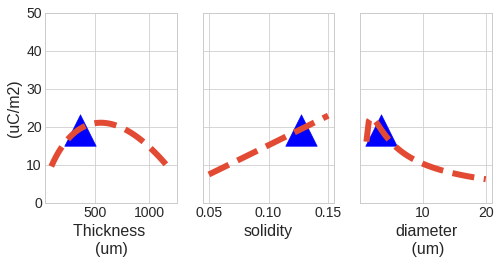

In [40]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.facecolor'] = 'none'


fig, ax = plt.subplots(1,3, figsize=(8,3.5), sharey=True)


#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u
h = set_h

J =  (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[0].plot(x*pow(10,6), J*pow(10,6), linestyle="--", linewidth = 6)
ax[0].scatter(set_thickness*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[0].set_xlabel("Thickness \n(um)", fontsize=16)
ax[0].set_ylabel("(uC/m2)", fontsize=16)
ax[0].tick_params(axis = 'x', labelsize=14)
ax[0].tick_params(axis = 'y', labelsize=14)
ax[0].set_ylim(0,50)



#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.15)
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


ax[1].plot(y,J*pow(10,6), linestyle="--", linewidth = 6)
ax[1].scatter(set_solidity, set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[1].set_xlabel("solidity", fontsize=16)

ax[1].tick_params(axis = 'x', labelsize=14)
ax[1].tick_params(axis = 'y', labelsize=14)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(1, 20)*pow(10,-6)
u = set_u
h = set_h

J =  (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[2].plot(z*pow(10,6),J*pow(10,6), linestyle="--", linewidth = 6)
ax[2].scatter(set_diameter*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[2].set_xlabel("diameter\n (um)", fontsize=16)




ax[2].tick_params(axis = 'x', labelsize=14)
ax[2].tick_params(axis = 'y', labelsize=14)

In [41]:
simulation_df = pd.DataFrame()

#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


simulation_df['thickness (um)']=np.linspace(100, 1200)
simulation_df['charge (uC)_1']=J*pow(10,6)

#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.15)
z = set_diameter
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)




simulation_df['solidity']=y
simulation_df['charge (uC)_2']=J*pow(10,6)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(1, 20)*pow(10,-6)
u = set_u
h = set_h

J = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)



simulation_df['diameter (um)']=z*pow(10,6)
simulation_df['charge (uC)_3']=J*pow(10,6)

In [42]:
simulation_df.to_excel('simulation_df_PP.xlsx')

# Validation at different random seeds

In [22]:
=1

SyntaxError: ignored

In [ ]:
def get_index(random_state, data):
  kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
  train_indexs = []
  test_indexs = []
  for train_index, test_index in kf.split(data):
      train_indexs.append(train_index)
      test_indexs.append(test_index)
  index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
  return index

In [ ]:
def get_scores(n_fold, index, data):
  train_index = index.iloc[n_fold,0]
  test_index = index.iloc[n_fold,1]
  train, test = data.iloc[train_index], data.iloc[test_index]
  train_shape=train.shape
  test_shape=test.shape

  def func(X,a, w, c, m, n, p):
    x,y,z,u,h = X
    return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  x=train['thickness(m)'].to_numpy()
  y=train['solidity'].to_numpy()
  z=train['diameter(m)'].to_numpy()
  u=train['Interface(m)'].to_numpy()
  h=train['Humidity (%)'].to_numpy()
  j=train['ChargeDensity(C/m2)'].to_numpy()


  # initial guesses for a,b,c,m,n,p:
  p0 = 1E-6 , 0 ,1. , 1. , 1., 1.

   # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=500000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=500000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  # print(trf_result)
  # print(dog_result)
  
  # Validate 
  
  data_val = pd.concat([train, test])
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Humidity (%)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape_trf = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_trf_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_trf_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])

  return n_fold, train_shape, test_shape, mape_trf, mape_trf_train, mape_trf_test

In [ ]:
max_random_sate = 100

In [ ]:
random_states = []
n_folds = []
train_shapes = []
test_shapes = []

MAPEs = []
train_MAPEs = []
test_MAPEs = []


for random_state in range(max_random_sate):
  index = get_index(random_state, data)
  for n_fold in range(5):
    random_states.append(random_state)
    n_fold, train_shape, test_shape, MAPE, train_MAPE, test_MAPE = get_scores(n_fold, index, data)
    n_folds.append(n_fold)
    train_shapes.append(train_shape)
    test_shapes.append(test_shape)
    
    MAPEs.append(MAPE)
    train_MAPEs.append(train_MAPE)
    test_MAPEs.append(test_MAPE)


In [ ]:
summary = pd.DataFrame()
summary['random_state']=random_states
summary['n_fold']=n_folds
summary['train_shape'] = train_shapes
summary['test_shape'] = test_shapes

summary['MAPE'] = MAPEs
summary['train_MAPE'] = train_MAPEs
summary['test_MAPE'] = test_MAPEs

summary

In [ ]:
summary.describe()

In [ ]:
summary.to_csv('100RandomState_PP.csv')